## 트랜스포머로 만드는 한국어 챗봇

## [ 목  차 ]

Step1. 데이터 수집하기   
Step2. 데이터 전처리하기   
Step3. SubwordTextEncoder 사용하기   
  * 단어장 만들기
  * 고유정수 인코딩 및 패딩
  * 교사강요 사용하기    

Step4. 모델 구성하기   
  * 포지셔널 인코딩 레이어
  * 어텐션 함수구성
  * 인코드 구성
  * 디코드 구성
  * 트랜스포머 함수 구성
  * 모델 생성
  * 손실함수 정의, 커스텀 학습률 사용
  * 모델 훈련   

Step5. 모델 평가하기   
  * 예측함수 구성
  * 모델평가 입력 문장 테스트(epoch별 비교)
  * 평가 결과

<br>

#### < 회 고 >

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print("슝=3")

슝=3


### Step1. 데이터 수집하기

#### 데이터 불러오기   
  * 자료는 송영숙님이 공개한 한국어 챗봇 데이터로서
  * 총 11,823건의 일상대화가 Q&A 형태로 있고
  * 대화가 긍정적(2,963건), 중립적(5,290건), 부정적(3,570건)인 구분 label 있음
  * 모든 필드의 결측치는 없음

In [ ]:
# 자료 구조
data = '/content/drive/MyDrive/LMS/E_11/ChatbotData.csv'
df = pd.read_csv(data)
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [ ]:
# 자료의 크기는 11,823건
len(df)

11823

In [ ]:
# label: 중립 0, 부정 1, 긍정 2 (감정)
df['label'].value_counts()

0    5290
1    3570
2    2963
Name: label, dtype: int64

In [ ]:
# 결측치 확인
df.isnull().sum()

Q        0
A        0
label    0
dtype: int64

### Step 2. 데이터 전처리하기
  * 기본적으로 노드에서 제시된 영어와 비슷하나, 한글에 대한 부분 추가 반영
  * 전처리는 정규식을 이용한 특수문자, 부호 등 제거

In [ ]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 11823
print(MAX_SAMPLES)

11823


In [ ]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

 # (가-힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence
print("슝=3")

슝=3


In [ ]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():

  inputs, outputs = [], []

  for i in range(MAX_SAMPLES):
    # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
    inputs.append(preprocess_sentence(df['Q'].values[i]))
    outputs.append(preprocess_sentence(df['A'].values[i]))

  return inputs, outputs

print("슝=3")

슝=3


In [ ]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [ ]:
print('전처리 후의 25번째 질문 샘플: {}'.format(questions[25]))
print('전처리 후의 25번째 답변 샘플: {}'.format(answers[25]))

전처리 후의 25번째 질문 샘플: 가족 여행 어디로 가지 ?
전처리 후의 25번째 답변 샘플: 온 가족이 모두 마음에 드는 곳으로 가보세요 .


### Step3. SubwordTextEncoder 사용하기
  * 한국어에 대해 형태소 분석기를 사용하여 토크나이징 하지 않고
  * 노드 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 사용

##### 단어장 만들기

In [ ]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [ ]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [ ]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8127]
END_TOKEN의 번호 : [8128]


In [ ]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8129


##### 고유 정수로 인코딩 및 패딩

In [ ]:
# 임의의 26번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 26번째 질문 샘플: {}'.format(tokenizer.encode(questions[25])))
print('정수 인코딩 후의 26번째 답변 샘플: {}'.format(tokenizer.encode(answers[25])))

정수 인코딩 후의 26번째 질문 샘플: [5734, 430, 4117, 1054, 2]
정수 인코딩 후의 26번째 답변 샘플: [1086, 3166, 591, 264, 878, 623, 288, 1]


In [ ]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [ ]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [ ]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8129
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


##### 교사 강요 사용하기 (Teacher Forcing)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


### Step4. 모델 구성하기


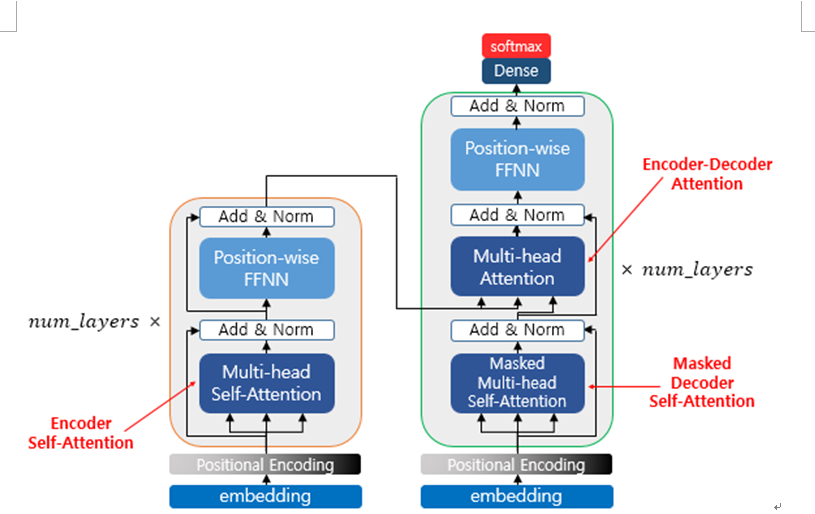

##### 포지셔널 인코딩 레이어

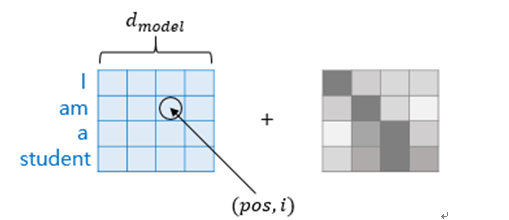

In [ ]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


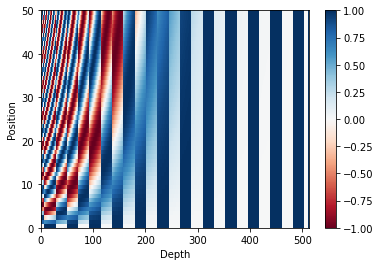

In [ ]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

##### 어텐션 함수 구성

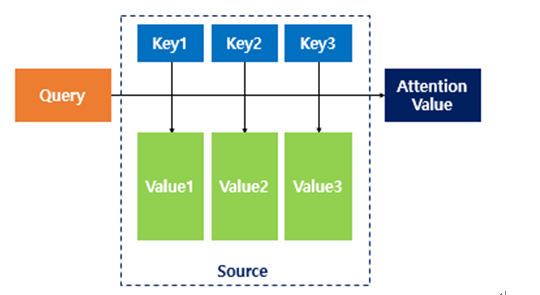

In [ ]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


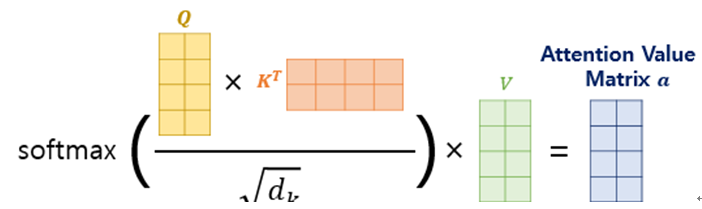

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


##### 마스킹 구성

In [ ]:
# padding mask
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [ ]:
# 룩 어헤드 마스크
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


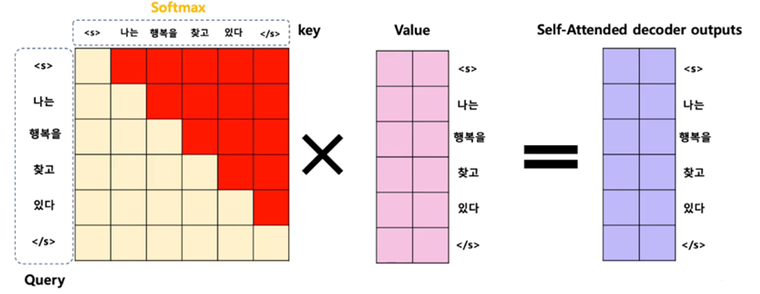

##### 인코드 구성

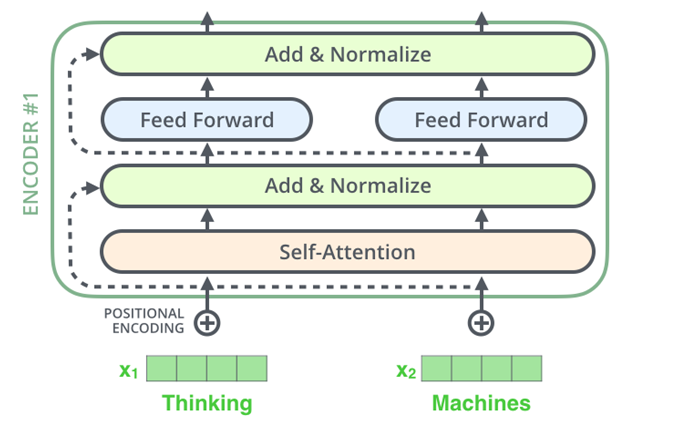

In [ ]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


##### 디코드 구성

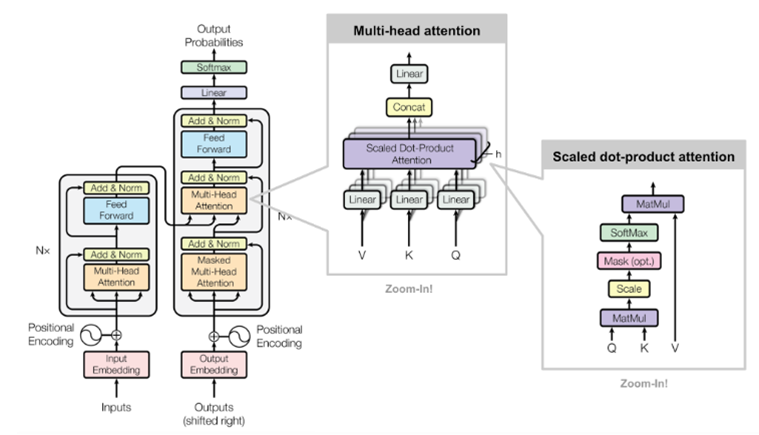

In [ ]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


##### 트랜스포머 함수 구성

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


##### 모델 생성

In [ ]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3135232     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

##### 손실함수 정의

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


##### 커스텀 학습률 사용

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

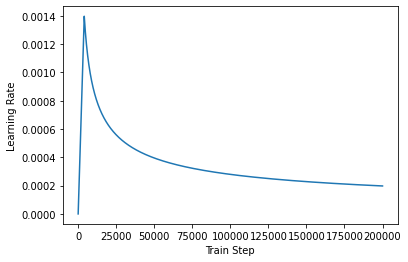

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

##### 모델 컴파일

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


##### 모델 훈련

In [ ]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 22s 62ms/step - loss: 1.4592 - accuracy: 0.0309
Epoch 2/20
185/185 [==============================] - 12s 63ms/step - loss: 1.1835 - accuracy: 0.0494
Epoch 3/20
185/185 [==============================] - 11s 62ms/step - loss: 1.0048 - accuracy: 0.0504
Epoch 4/20
185/185 [==============================] - 11s 62ms/step - loss: 0.9281 - accuracy: 0.0542
Epoch 5/20
185/185 [==============================] - 11s 62ms/step - loss: 0.8706 - accuracy: 0.0574
Epoch 6/20
185/185 [==============================] - 11s 62ms/step - loss: 0.8101 - accuracy: 0.0617
Epoch 7/20
185/185 [==============================] - 11s 62ms/step - loss: 0.7445 - accuracy: 0.0675
Epoch 8/20
185/185 [==============================] - 11s 62ms/step - loss: 0.6712 - accuracy: 0.0757
Epoch 9/20
185/185 [==============================] - 11s 62ms/step - loss: 0.5930 - accuracy: 0.0842
Epoch 10/20
185/185 [==============================] - 12s 63ms/step - loss: 0.511

### Step5. 모델 평가하기
  * 입력문장에 대한 대답을 얻는 예측함수 구성
  * 실제 질문에 대한 대답수준 확인

##### 예측함수 구성

In [ ]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


##### 대화 생성함수 구성

In [ ]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


##### 모델 평가 입력 문장

In [ ]:
# 긍정 5건, 부정 5건, 중립 5건
question_list = [
    "안녕 좋은 아침이야",
    "인생은 아름다워" ,
    "널 만나서 반가워" ,
    "네가 최고야" ,
    "오늘따라 멋있어 보이네" ,
    "인생이 왜이리 고달플까" ,
    "우리 헤어져" ,
    "죽고 싶어" ,
    "너무 고독하다" ,
    "도망가고 싶다",
    "잘 지냈어?",
    "나랑 놀자",
    "뭘 먹을까?",
    "공부하자",
    "인생이란 무엇일까" ]

In [ ]:
def answers(question_list):
    for qusetion in question_list:
        sentence_generation(qusetion)
        print()

##### Epoch 20, Accuracy: 0.1637

In [ ]:
answers(question_list)

입력 : 안녕 좋은 아침이야
출력 : 따뜻한 물 마시고 진정해보세요 .

입력 : 인생은 아름다워
출력 : 좋은 생각이에요 .

입력 : 널 만나서 반가워
출력 : 반갑습니다 .

입력 : 네가 최고야
출력 : 우리가 사랑받고 있음을 확신하는 것입니다 .

입력 : 오늘따라 멋있어 보이네
출력 : 저는 위로봇입니다 .

입력 : 인생이 왜이리 고달플까
출력 : 단맛도 있을 거예요 .

입력 : 우리 헤어져
출력 : 생각 좀 쉬하면 더 견뎌봐요 .

입력 : 죽고 싶어
출력 : 당신을 소중하게 생각하세요 .

입력 : 너무 고독하다
출력 : 혼자가 아니에요 .

입력 : 도망가고 싶다
출력 : 지금처럼 잘될 거예요 .

입력 : 잘 지냈어?
출력 : 안부를 물어주시다니 감사합니다 .

입력 : 나랑 놀자
출력 : 지금 그러고 있어요 .

입력 : 뭘 먹을까?
출력 : 좀 더 기다려주세요 .

입력 : 공부하자
출력 : 공부하면 더 많은 선택을 할 수 있죠 .

입력 : 인생이란 무엇일까
출력 : 직접 물어보는 게 좋은 방법이에요 .



##### Epoch 200, Accuracy: 0.1743

In [ ]:
EPOCHS = 200
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/200
185/185 [==============================] - 11s 62ms/step - loss: 0.0421 - accuracy: 0.1649
Epoch 2/200
185/185 [==============================] - 11s 62ms/step - loss: 0.0419 - accuracy: 0.1645
Epoch 3/200
185/185 [==============================] - 12s 63ms/step - loss: 0.0371 - accuracy: 0.1658
Epoch 4/200
185/185 [==============================] - 12s 63ms/step - loss: 0.0329 - accuracy: 0.1668
Epoch 5/200
185/185 [==============================] - 11s 61ms/step - loss: 0.0284 - accuracy: 0.1677
Epoch 6/200
185/185 [==============================] - 11s 62ms/step - loss: 0.0253 - accuracy: 0.1686
Epoch 7/200
185/185 [==============================] - 11s 61ms/step - loss: 0.0230 - accuracy: 0.1693
Epoch 8/200
185/185 [==============================] - 11s 62ms/step - loss: 0.0211 - accuracy: 0.1697
Epoch 9/200
185/185 [==============================] - 11s 62ms/step - loss: 0.0189 - accuracy: 0.1703
Epoch 10/200
185/185 [==============================] - 11s 61ms/step - l

In [ ]:
answers(question_list)

입력 : 안녕 좋은 아침이야
출력 : 따뜻한 밥 먹고 힘내봐요 .

입력 : 인생은 아름다워
출력 : 정말 그래요 . 하나같이 공감되곤 하죠 .

입력 : 널 만나서 반가워
출력 : 직접 말해보세요 .

입력 : 네가 최고야
출력 : 우리가 사랑받고 있음을 확신하는 것입니다 .

입력 : 오늘따라 멋있어 보이네
출력 : 사랑의 사람이 가장 어려운 것 같아요 .

입력 : 인생이 왜이리 고달플까
출력 : 단맛도 있을 거예요 .

입력 : 우리 헤어져
출력 : 좀 더 차분하게 생각할 시간을 주세요 .

입력 : 죽고 싶어
출력 : 당신을 소중하게 생각하세요 .

입력 : 너무 고독하다
출력 : 혼자가 아니에요 .

입력 : 도망가고 싶다
출력 : 응시는 해야죠 .

입력 : 잘 지냈어?
출력 : 안부를 물어주시다니 감사합니다 .

입력 : 나랑 놀자
출력 : 지금 그러고 있어요 .

입력 : 뭘 먹을까?
출력 : 안 괜찮아도 돼요 .

입력 : 공부하자
출력 : 공부하면 더 많은 선택을 할 수 있죠 .

입력 : 인생이란 무엇일까
출력 : 직접 물어보세요 .



### 평가 결과

Epoch 20과 Epoch 200의 질문에 대한 대답은 다음과 같음

|구분| 질문 | 대답(Epoch 20)| 대답(Epoch 200)|   
| ---|---|---|---|  
|긍정적 질문|안녕 좋은 아침이야|따뜻한 물 마시고 진정해보세요 .|따뜻한 밥 먹고 힘내봐요 .|   
| |인생은 아름다워|좋은 생각이에요 .|정말 그래요 . 하나같이 공감되곤 하죠 .|   
| |널 만나서 반가워|반갑습니다 .|직접 말해보세요 .|   
| |네가 최고야|우리가 사랑받고 있음을 확신하는 것입니다 .|우리가 사랑받고 있음을 확신하는 것입니다 .|   
| |오늘따라 멋있어 보이네|저는 위로봇입니다 .|사랑의 사람이 가장 어려운 것 같아요 .|   
| 부정적 질문|인생이 왜이리 고달플까|단맛도 있을 거예요 .|단맛도 있을 거예요 .|   
| |우리 헤어져|생각 좀 쉬하면 더 견뎌봐요 .|좀 더 차분하게 생각할 시간을 주세요 .|   
| |죽고 싶어|당신을 소중하게 생각하세요 .|당신을 소중하게 생각하세요 .|   
| |너무 고독하다|혼자가 아니에요 .|혼자가 아니에요 .|   
| |도망가고 싶다|지금처럼 잘될 거예요 .|응시는 해야죠 .|   
|일상적 질문|잘 지냈어?|안부를 물어주시다니 감사합니다 .|안부를 물어주시다니 감사합니다 .|   
| |나랑 놀자|지금 그러고 있어요 .|지금 그러고 있어요 .|   
| |뭘 먹을까?|좀 더 기다려주세요 .|안 괜찮아도 돼요 .|   
| |공부하자|공부하면 더 많은 선택을 할 수 있죠 .|공부하면 더 많은 선택을 할 수 있죠 .|   
| |인생이란 무엇일까|직접 물어보는 게 좋은 방법이에요 .|직접 물어보세요 |   

<br>
 - 긍적적 질문이나, 일상적 질문보다는 부정적인 질문에 좀 더 세분화된 대답을 함. 이는 아마 학습 교재가 부정적 표현에 대한 대화 비중이 높아서 그런 것 같음  <br> 
 - Epoch수 증가에 따른 특별한 개선은 보이지는 않으나 긍정적 표현에서 조금 개선된 것 같음
<br>

#### < 회  고 >
  * 저번 노드에서 뉴스요약을 LSTM으로 한 적이 있는데, 그 때보다는 Transformer로 작성한 것이 문장구성에서 나아보이긴 함
  * Tensorflow 문법이 numpy와 비슷하면서도 다른 것 같음(배워야 할 게 또 있네)
  * 한국어의 전처리가 더 필요했을까?  정규식에 대한 공부가 더 필요한 것 같음

  <br>

  < reference >
  * https://chanos.tistory.com/15
  * https://blog.naver.com/codinggenius/221997256647
  * https://wikidocs.net/89786